---
title: Atomic Models
authors: [gvarnavides]
date: 2025-02-01
---

In [6]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets

import ase
import abtem

## Unit-cells

In [2]:
N2_molecule = ase.Atoms(
    positions=np.array([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]),
    symbols=["N", "N"],  # "N2" also works
    cell=[6.0, 6.0, 6.0, 90, 90, 90],  # [6.0,6.0,6.0] also works
)

In [3]:
Si3N4_crystal = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)

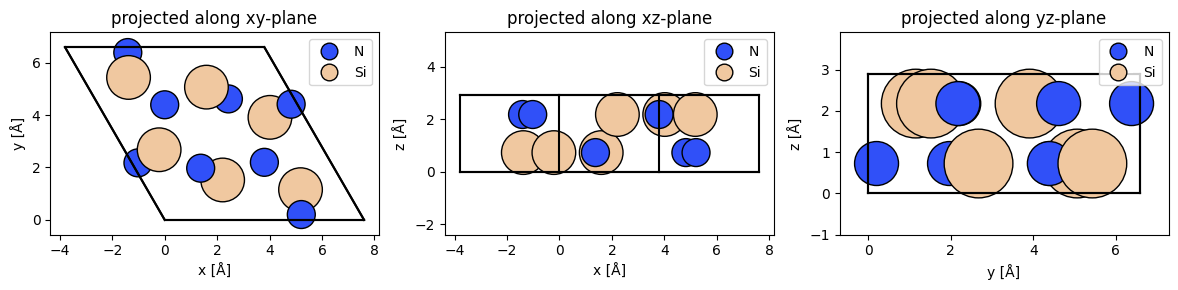

In [4]:
#| label: app:unit_cell_projections

with plt.ioff():
    fig, axs = plt.subplots(1,3,figsize=(12,3))

for ax, plane in zip(axs,['xy','xz','yz']):
    abtem.show_atoms(
        Si3N4_crystal,
        plane=plane,
        title=f"projected along {plane}-plane",
        ax=ax,
        legend=True,
    )

fig.tight_layout()
fig

## Super-cells

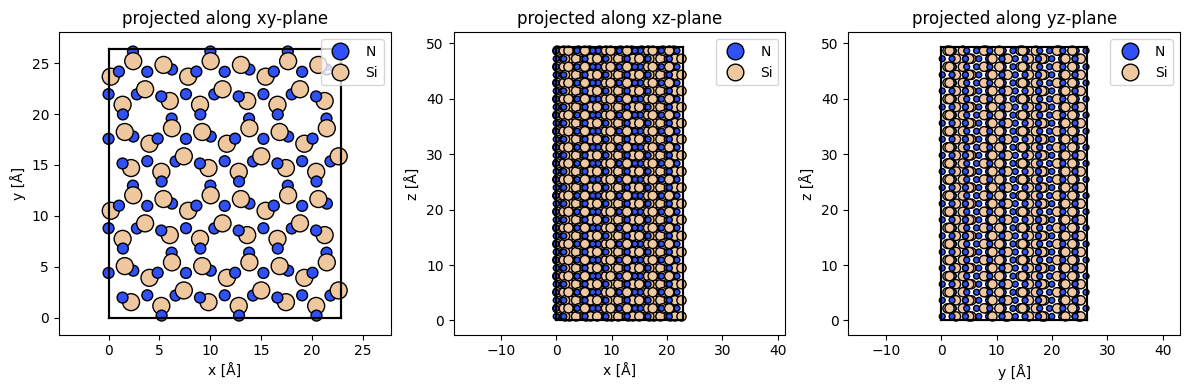

In [5]:
#| label: app:super_cell_projections

Si3N4_orthorhombic = abtem.orthogonalize_cell(Si3N4_crystal)
Si3N4_orthorhombic *= (3,2,17)

with plt.ioff():
    fig, axs = plt.subplots(1,3,figsize=(12,4))

for ax, plane in zip(axs,['xy','xz','yz']):
    abtem.show_atoms(
        Si3N4_orthorhombic,
        plane=plane,
        title=f"projected along {plane}-plane",
        ax=ax,
        legend=True,
    )

fig.tight_layout()
fig

## Interactive Super-cell Widget

In [56]:
srtio3 = ase.io.read("data/SrTiO3.cif")

# widget figure generation
with plt.ioff():
    dpi = 72
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(675/dpi, 275/dpi), dpi=dpi)

# fig.tight_layout()
fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '315px'
fig.canvas.toolbar_position = 'bottom'

def return_sto_supercell(x, y, z, vac, axis):
    """ """
    if axis == [1,1,1]:
        layers = 3
        z = np.clip(z // 3,1,np.inf).astype("int")
    elif axis == [1,1,0]:
        layers = 2
        z =  np.clip(z // 2,1,np.inf).astype("int")
    elif axis == [1,0,0]:
        layers = 2
        z =  np.clip(z // 2,1,np.inf).astype("int")
    else:
        raise ValueError()
    
    cell = ase.build.surface(srtio3, indices=axis, layers=layers, periodic=True)
    cell = abtem.orthogonalize_cell(cell)
    cell.wrap()
    cell *= (x,y,z)
    cell.center(vac, axis=2)

    ax1.cla()
    ax2.cla()
    top = abtem.show_atoms(cell, ax=ax1,show_periodic = True)
    beam = abtem.show_atoms(cell, ax=ax2, plane='yz', show_periodic=True, legend=True)
    fig.canvas.draw_idle()
    
    return None

In [59]:
style = {
    'description_width': 'initial',
}

layout = ipywidgets.Layout(width='325px',height='30px')

dropdown = ipywidgets.Dropdown(
    options = [[1,0,0],[1,1,0],[1,1,1]],
    value=[1,1,0],
    layout=layout,
    style=style,
    description='Zone axis:     ',
)

sliderx = ipywidgets.IntSlider(
    orientation='horizontal',
    description='x repetitions: ',
    value=4,
    min=1,
    max=10,
    style = style,
    layout=layout,
)

slidery = ipywidgets.IntSlider(
    orientation='horizontal',
    description='y repetitions: ',
    value=4,
    min=1,
    max=10,
    style = style,
    layout=layout,
)

sliderz = ipywidgets.IntSlider(
    orientation='horizontal',
    description='z repetitions: ',
    value=4,
    min=1,
    max=10,
    style = style,
    layout=layout,
)

slidervac = ipywidgets.FloatSlider(
    orientation='horizontal',
    description='vacuum (A): ',
    value=2,
    min=1,
    max=10,
    step=1,
    style = style,
    layout=layout,
)

ipywidgets.interactive_output(
    return_sto_supercell, 
    {
        'x':sliderx,
        'y':slidery,
        'z':sliderz,
        'vac':slidervac,
        'axis':dropdown
    },
)
None

In [60]:
#| label: app:sto_supercell

display(
    ipywidgets.VBox(
        [
            fig.canvas,
            ipywidgets.HBox([
                ipywidgets.VBox([
                    sliderx,
                    slidery,
                    sliderz,
                ]),
                ipywidgets.VBox([
                    slidervac,
                    dropdown,
                ])
            ]),
        ],
    )
)